In [76]:
from cv2.quality import QualitySSIM
import numpy as np
import cv2
import matplotlib.pyplot as plt

In [77]:
# Per aggiungere il rumore e capire che rumore c'era originariamente
def add_noise_to_image(image, noise_type, parameters:dict):
    match noise_type:
        case "random" :
            '''
            parameter example
            {
                "scale" : 20,
            }
            '''
            noise = np.random.normal(**(parameters), size=image.shape)
            noisy_image = np.clip(image - noise, 0, 225).astype(np.uint8)
            return noisy_image
        
        case "normal" :
            '''
            parameter example
            {
                "loc" : 25,
                "scale" : 100
            }
            '''
            noise = np.random.normal(**(parameters), size=image.shape)
            noisy_image = np.clip(image - noise, 0, 225).astype(np.uint8)
            return noisy_image
        
        case _: ValueError("Unsupported noise type")
    return noisy_image

In [78]:
def denoise_image(image, filters):
    for filter in filters:
        for _ in range(filter['n_iter']):
            match filter['name']:
                case "mean":
                    '''
                    {"ksize" : 15}
                    '''
                    k_size = filter['params']['ksize']
                    mean_kernel = np.ones([k_size, k_size])/(k_size**2)
                    image = cv2.filter2D(image, -1, mean_kernel)

                case "median":
                    '''
                    {"ksize" : 11}
                    '''
                    image = cv2.medianBlur(image, **filter['params'])

                case "bilateral":
                    '''
                    {"d" : 3,
                    "sigmaColor" : 2,
                    "sigmaSpace" : 1.5}
                    '''
                    image = cv2.bilateralFilter(image, **filter['params'])

                case 'gaussian':
                    '''
                    {"sigmaX" : 2}
                    '''
                    sigmaX = filter['params']['sigmaX']
                    ksize = 2*int(np.ceil(3*sigmaX)) + 1
                    image = cv2.GaussianBlur(image, (ksize, ksize), sigmaX)

                case 'non_local_means':
                    '''
                    {'templateWindowSize':5,"searchWindowSize":21, "h":3, "hColor": 20}
                    '''
                    image = cv2.fastNlMeansDenoisingColored(image, **filter['params'])

                case 'canny':
                    '''
                    {'threshold1':5,"threshold2":21}
                    '''
                    image = cv2.Canny(image, **filter['params'])

                case 'sharpen':
                    kernel = np.array([[0, -1, 0],
                                       [-1, 5, -1],
                                       [0, -1, 0]])
                    image = cv2.filter2D(image, -1, kernel=kernel)

                case 'emboss':
                    kernel = np.array([[-2, -1, 0],
                                       [-1, 1, 1],
                                       [0, 1, 2]])
                    image = cv2.filter2D(image, -1, kernel=kernel)
                case _: pass
    return image

def normalize(image):
    return (image.astype(float)*255.0/225).astype('uint8')

In [79]:
# img_original = cv2.imread("/Users/pelle/Desktop/dataset/models/ref21.png")[:,:,::-1]; plt.subplot(131); plt.imshow(img_original)
# img_noised = add_noise_to_image(img_original, 'random', {"intensity" : 100}); plt.subplot(132); plt.imshow(img_noised)
# filters = [
#     {'name': "median",
#         "n_iter": 1,
#         "params": {"ksize": 3}
#      },
#     {'name': "median",
#         "n_iter": 0,
#         "params": {"ksize": 5}
#      },
#     {'name': "median",
#         "n_iter": 1,
#         "params": {"ksize": 7}
#      },
#     {'name': "median",
#         "n_iter": 0,
#         "params": {"ksize": 9}
#      },
# ]
# image_denoised = denoise_image(img_noised, filters=filters); plt.subplot(133); plt.imshow(image_denoised)

# comparator = QualitySSIM()
# retval, qualityMap = comparator.compute(img_original, image_denoised)
# # retval, qualityMap = cv2.quality.QualitySSIM_compute([img_original], [img_noised])

# print(f"Comparison result: {retval}")

In [80]:
scenes_B={i:f"/Users/pelle/Desktop/dataset/scenes/scene{i}.png" for i in range(6,13)}

img_shapes = {
    6: (1072, 1514),
    7: (766, 1146),
    8: (1014, 1504),
    9: (662, 1488),
    10: (932, 1696),
    11: (674, 1482),
    12: (704, 1626),
}

positions = {
    8: {
        'c': [10, 450, 820, 1160, img_shapes[8][1]],
        'r': [180, img_shapes[8][0]]
    },
    9: {
        'c': [0, 230, 490, 730, 970, 1230, 1470],
        'r': [150, img_shapes[9][0]]
    },
    10: {
        'c': [580, 840, 1120, 1390, 1650],
        'r': [200, 850]
    },
    11: {
        'c': [70, 255, 450, 650, 840, 1035, 1240, 1440],
        'r': [120, 620]
    },
    12: {
        'c': [0, 280, 560, 815, 1070, 1345, 1610],
        'r': [150, 150+570]
    },
}

checks = {
    8: {
        0:[18,26,27],1:[17,23,24],2:[17,23,24],3:[17,23,24]
    },
    9: {
        0:[18,20,26,27],1:[18,20,26,27],2:[18,19,26,27],3:[18,19,26,27],4:[20],5:[20]
    },
    10: {
        0: [21,22,23], 1: [21,22,23], 2: [21,22,23], 3: [21,22,23]
    },
    11: {
        0: [17,23,24], 1: [17,23,24], 2: [17,23,24], 3: [17,23,24],4:[25],5:[25],6:[25]
    },
    12: {
        0:[18,26,27],1:[18,26,27],2:[18,26,27],3:[18,26,27],4:[18,26,27],5:[18,26,27]
    },
}

true = {
    8: {
        0: 27, 1: 23, 2: 23, 3: 24
    },
    9: {
        0: 18, 1: 18, 2: 19, 3: 19, 4: 20, 5: 20
    },
    10: {
        0: 21, 1: 21, 2: 22, 3: 22
    },
    11: {
        0: 23, 1: 23, 2: 24, 3: 24, 4: 25, 5: 25, 6: 25
    },
    12: {
        0: 26, 1: 26, 2: 27, 3: 27, 4: 18, 5: 18
    }
}

# scene_images={}
# for scene in positions:
#     fig, axes = plt.subplots(1, len(positions[scene]['c'])-1, figsize=(2+2*len(positions[scene]['c']), 4),squeeze=False)
#     axes = axes.flatten()

#     image=cv2.cvtColor(cv2.imread(scenes_B[scene]), cv2.COLOR_BGR2RGB)
#     l=positions[scene]['c'][0]
#     r1,r2=positions[scene]['r']
#     scene_images[scene]={}
#     for i,r in enumerate(positions[scene]['c'][1:]):
#         scene_images[scene][i]=image[r1:r2,l:r].copy()
#         axes[i].imshow(image[r1:r2,l:r],extent=[l,r,r2-r1,0],aspect='equal')
#         l=r

#     plt.tight_layout()
#     plt.show()
    
def extract_product_crops_in_scene(product_number, scene_number):
    scene_image = cv2.cvtColor(cv2.imread(scenes_B[scene_number]), cv2.COLOR_BGR2RGB)
    crops = []

    valid_cuts = [idx for idx in true[scene_number] if true[scene_number][idx]==product_number]

    l = positions[scene_number]['c'][0]
    r1, r2 = positions[scene_number]['r']
    for i, r in enumerate(positions[scene_number]['c'][1:]):
        crop = scene_image[r1:r2, l:r].copy()
        if (i in valid_cuts) : crops.append(crop)
        l = r

    return crops

5


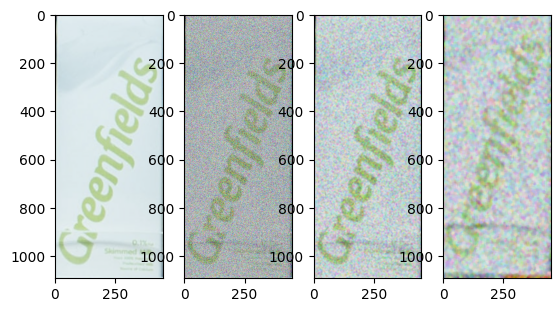

Comparison result among 3rd and 4th: (0.37386909777308974, 0.40798791138485774, 0.3905525679666997, 0.0)
5


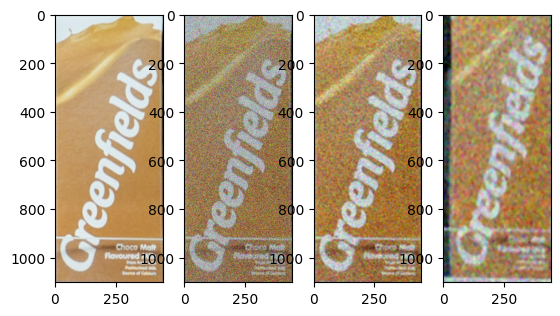

Comparison result among 3rd and 4th: (0.34072192442928906, 0.31765197726319766, 0.291277171775875, 0.0)
5


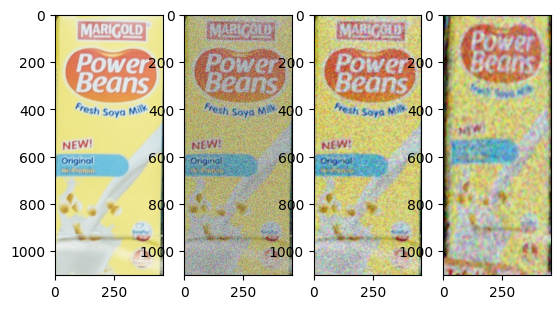

Comparison result among 3rd and 4th: (0.36496053799750683, 0.3234594543287406, 0.2808645228471924, 0.0)
5


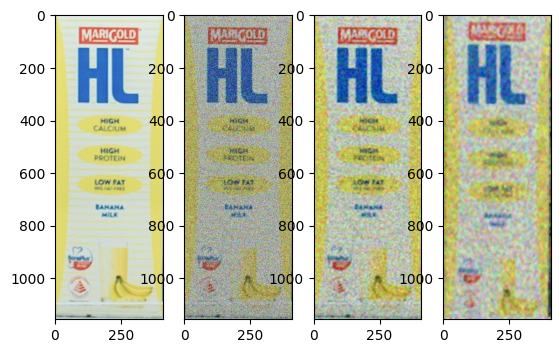

Comparison result among 3rd and 4th: (0.3448590312330161, 0.3388056601197449, 0.2961435908759719, 0.0)
5


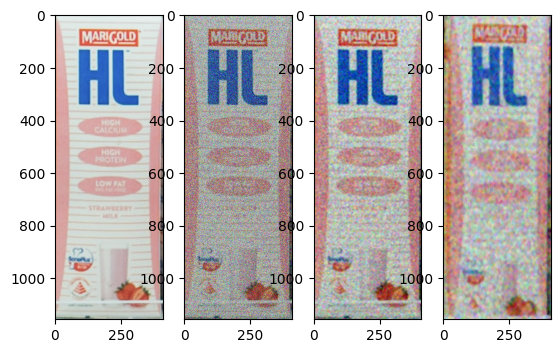

Comparison result among 3rd and 4th: (0.3236459366088723, 0.30575723793842857, 0.30393318461789687, 0.0)
5


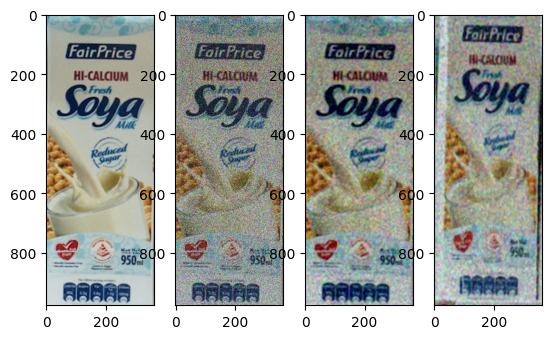

Comparison result among 3rd and 4th: (0.194659692854535, 0.19573432848978103, 0.19677297950059397, 0.0)
5


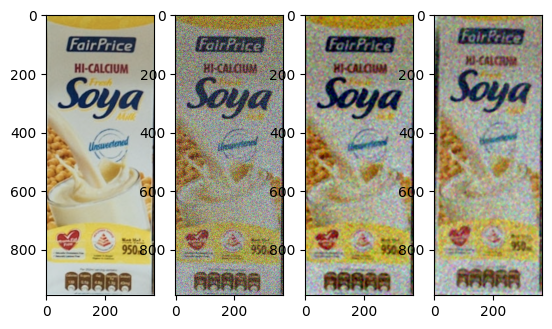

Comparison result among 3rd and 4th: (0.2391117039346775, 0.22834293366903435, 0.22411397665044758, 0.0)
5


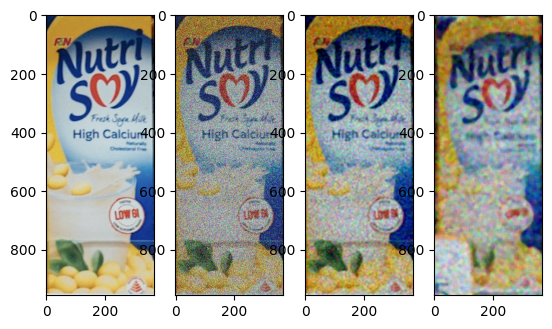

Comparison result among 3rd and 4th: (0.27352589866392496, 0.28026560392247096, 0.2833466551771875, 0.0)
5


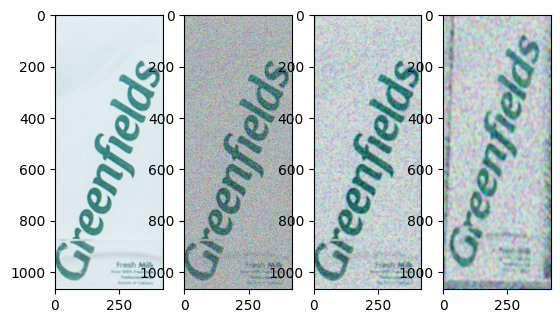

Comparison result among 3rd and 4th: (0.29557955564907656, 0.34964662872129065, 0.3671425692048124, 0.0)
5


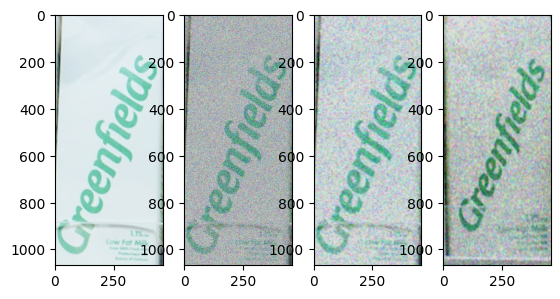

Comparison result among 3rd and 4th: (0.27571270554012534, 0.32252005798230604, 0.3173249867246644, 0.0)


In [86]:
for i in range(18, 28) :
    path = f"/Users/pelle/Desktop/dataset/models/ref{i}.png"
    img_original = cv2.imread(path)[:,:,::-1]; plt.subplot(141); plt.imshow(img_original)
    
    # img_noised = add_noise_to_image(img_original, 'random', {"intensity" : 100}); plt.subplot(142); plt.imshow(img_noised)
    img_noised = add_noise_to_image(img_original, 'normal', {"loc" : 25,"scale" : 100}); plt.subplot(142); plt.imshow(img_noised)
    
    filters = [
        {'name': "median",
            "n_iter": 1,
            "params": {"ksize": 3}
        },
        {'name': "median",
            "n_iter": 0,
            "params": {"ksize": 5}
        },
        {'name': "median",
            "n_iter": 1,
            "params": {"ksize": 7}
        },
        {'name': "median",
            "n_iter": 0,
            "params": {"ksize": 9}
        },
    ]
    image_denoised = denoise_image(img_noised, filters=filters); plt.subplot(143); plt.imshow(image_denoised)
    
    prods_num_item = [extract_product_crops_in_scene(i, j) for j in range(8,13)]
    print(len(prods_num_item))
    tmp = []
    for j in range(len(prods_num_item)) : tmp+=prods_num_item[j] # lista di liste -> lista
    image_scene_cut = tmp
    image_scene_cut_denoised = [denoise_image(img, filters) for img in tmp]
    
    # for i, img in enumerate(tmp) : plt.subplot(1, len(tmp), i+1); plt.imshow(img)
    # Choose the first by chance
    image_scene_cut_denoised_resized = cv2.resize(image_scene_cut_denoised[0], 
                                                  (img_original.shape[1], img_original.shape[0]))
    plt.subplot(144); plt.imshow(image_scene_cut_denoised_resized); plt.show()
    
    comparator = QualitySSIM()
    # retval, qualityMap = comparator.compute(image_scene_cut, image_scene_cut_denoised_resized)
    retval, qualityMap = comparator.compute(image_denoised, image_scene_cut_denoised_resized)
    # retval, qualityMap = cv2.quality.QualitySSIM_compute([img_original], [img_noised])

    print(f"Comparison result among 3rd and 4th: {retval}")

In [74]:
comparator = QualitySSIM()
refs = {num : cv2.imread(f"/Users/pelle/Desktop/dataset/models/ref{num}.png")[:,:,::-1] for num in [18, 26, 27]}

for num, ref in refs.items() :
    for n in refs.keys() : 
        prods_num_item = [extract_product_crops_in_scene(n, j) for j in range(8,13)]
        tmp = []
        for j in range(len(prods_num_item)) : tmp+=prods_num_item[j] # lista di liste -> lista
        image_scene_cut = tmp
        image_scene_cut_denoised = [denoise_image(img, filters) for img in tmp]
        image_scene_cut_denoised_resized = cv2.resize(image_scene_cut_denoised[0], 
                                                  (ref.shape[1], ref.shape[0]))
        
        retval, _ = comparator.compute(ref, image_scene_cut_denoised_resized)
        print(f'ref{num} x cut{n}: \t{retval}')

ref18 x cut18: 	(0.6822719271875548, 0.7111629935008567, 0.6536796175697188, 0.0)
ref18 x cut26: 	(0.5624145411277827, 0.6076238418161869, 0.5926890304374021, 0.0)


ref18 x cut27: 	(0.4622670502112228, 0.5029033728215896, 0.4620660145447834, 0.0)
ref26 x cut18: 	(0.5905657670132138, 0.6359064741949304, 0.6169572013039937, 0.0)
ref26 x cut26: 	(0.5081392736264763, 0.5589460106906786, 0.5655908814950907, 0.0)
ref26 x cut27: 	(0.42314840662490116, 0.4618100433077647, 0.4417054031727492, 0.0)
ref27 x cut18: 	(0.6161886227071519, 0.6788482574877006, 0.6397661956202227, 0.0)
ref27 x cut26: 	(0.5350078683975942, 0.5965518885559186, 0.5933258654406509, 0.0)
ref27 x cut27: 	(0.44301123306028145, 0.4919792783340427, 0.464530958246606, 0.0)


## TODO:

1. Denoise scena
2. Ritaglia prodotto
3. Prendi reference del prodotto e fai noise e poi denoise
4. Differenca tra i due